In [2]:
# Standard imports
import pandas as pd
import numpy as np

In [3]:
# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [5]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(solver='lbfgs')
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier(max_depth=4)
from sklearn.svm import LinearSVC
linearsvc = LinearSVC()
from sklearn.svm import SVC
svc = SVC(kernel='poly', gamma='auto')
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(n_estimators=10)

In [6]:
# For SQL queries
import sqlite3
conn = sqlite3.connect("/Users/Quicksilver/Desktop/Metis/sea19_ds10/Project03/FPA_FOD_20170508.sqlite")
cursor=conn.cursor()

# Get stuff from pickles

In [7]:
import pickle

to retrieve from pickles: columns_df_abbrev_west, west_df, cause_codes_dict, fireworks_df

In [8]:
with open('columns_df_abbrev_west.pickle','rb') as read_file:
    columns_df_abbrev_west = pickle.load(read_file)

In [9]:
columns_df_abbrev_west

,FPA_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE
0,FS-1418826,2005,33,9.0,Miscellaneous,33,0.10,A,40.036944,-121.005833,CA
1,FS-1418827,2004,133,1.0,Lightning,133,0.25,A,38.933056,-120.404444,CA
2,FS-1418835,2004,152,5.0,Debris Burning,152,0.10,A,38.984167,-120.735556,CA
3,FS-1418845,2004,180,1.0,Lightning,185,0.10,A,38.559167,-119.913333,CA
4,FS-1418847,2004,180,1.0,Lightning,185,0.10,A,38.559167,-119.933056,CA


In [10]:
with open('west_df.pickle','rb') as read_file:
    west_df = pickle.load(read_file)

In [11]:
west_df.head()

,fire_id,year,discovery_doy,cause_code,cause_descr,contained_doy,fire_size,fire_size_class,lat,long,state
0,FS-1418826,2005,33,9.0,Miscellaneous,33.0,0.10,A,40.036944,-121.005833,CA
1,FS-1418827,2004,133,1.0,Lightning,133.0,0.25,A,38.933056,-120.404444,CA
2,FS-1418835,2004,152,5.0,Debris Burning,152.0,0.10,A,38.984167,-120.735556,CA
3,FS-1418845,2004,180,1.0,Lightning,185.0,0.10,A,38.559167,-119.913333,CA
4,FS-1418847,2004,180,1.0,Lightning,185.0,0.10,A,38.559167,-119.933056,CA


In [12]:
with open('cause_codes_dict.pickle','rb') as read_file:
    cause_codes_dict = pickle.load(read_file)

In [13]:
cause_codes_dict

{1.0: 'Lightning',
 2.0: 'Equipment Use',
 3.0: 'Smoking',
 4.0: 'Campfire',
 5.0: 'Debris Burning',
 6.0: 'Railroad',
 7.0: 'Arson',
 8.0: 'Children',
 9.0: 'Miscellaneous',
 10.0: 'Fireworks',
 11.0: 'Powerline',
 12.0: 'Structure',
 13.0: 'Missing/Undefined'}

In [14]:
with open('fireworks_df.pickle','rb') as read_file:
    fireworks_df = pickle.load(read_file)

In [15]:
fireworks_df.head()

,Discovery DOY,COUNT
0,1,52
1,2,8
2,3,5
3,4,11
4,5,3


# Separate out the 'Missing/Undefined' fires

In [16]:
cause_missing = west_df.copy()

In [17]:
west_df.shape

(296994, 11)

In [18]:
# df1 = df[df.age == 75]
# df2 = df[df.age == 22]
cause_missing = cause_missing[cause_missing.cause_code == 13.0]
cause_missing.shape

(14947, 11)

In [19]:
# check that removed rows + remaining rows = west_df.shape

cause_not_missing = west_df.copy()
cause_not_missing = cause_not_missing[cause_not_missing.cause_code != 13.0]
cause_not_missing.shape

(282047, 11)

In [20]:
282047+14947

296994

The number of rows with 'Missing/Undefined' is as expected, so proceed by removing those rows from the main df.

In [21]:
model2_df = cause_not_missing.copy()

In [22]:
model2_df.head()

,fire_id,year,discovery_doy,cause_code,cause_descr,contained_doy,fire_size,fire_size_class,lat,long,state
0,FS-1418826,2005,33,9.0,Miscellaneous,33.0,0.10,A,40.036944,-121.005833,CA
1,FS-1418827,2004,133,1.0,Lightning,133.0,0.25,A,38.933056,-120.404444,CA
2,FS-1418835,2004,152,5.0,Debris Burning,152.0,0.10,A,38.984167,-120.735556,CA
3,FS-1418845,2004,180,1.0,Lightning,185.0,0.10,A,38.559167,-119.913333,CA
4,FS-1418847,2004,180,1.0,Lightning,185.0,0.10,A,38.559167,-119.933056,CA


# Create combined categories for cause_descr

In [23]:
# look at the cause codes
cause_codes_dict

{1.0: 'Lightning',
 2.0: 'Equipment Use',
 3.0: 'Smoking',
 4.0: 'Campfire',
 5.0: 'Debris Burning',
 6.0: 'Railroad',
 7.0: 'Arson',
 8.0: 'Children',
 9.0: 'Miscellaneous',
 10.0: 'Fireworks',
 11.0: 'Powerline',
 12.0: 'Structure',
 13.0: 'Missing/Undefined'}

Cause categories:
 - natural/human_industrial/human_recreational/miscellaneous

In [24]:
# How many of each cause? Count for later verification.
cause_counts = model2_df[['cause_descr','fire_id']].groupby('cause_descr').count()

In [25]:
def categorize(cause_code):
    human_rec = [3.0, 4.0, 7.0, 8.0, 10.0]
    if cause_code == 9.0:
        # return category
        return "misc"        
    elif cause_code == 1.0:
        return "natural"
    elif cause_code in human_rec:
        return "human_rec"
    else:
        return "human_ind"

In [26]:
# test the "categorize" function
categorize(4)

'human_rec'

In [27]:
# create column in model2_df for new categories by applying "categorize" function to cause_code

model2_df['cause_category']=model2_df['cause_code'].apply(categorize)

In [28]:
model2_df.head()

,fire_id,year,discovery_doy,cause_code,cause_descr,contained_doy,fire_size,fire_size_class,lat,long,state,cause_category
0,FS-1418826,2005,33,9.0,Miscellaneous,33.0,0.10,A,40.036944,-121.005833,CA,misc
1,FS-1418827,2004,133,1.0,Lightning,133.0,0.25,A,38.933056,-120.404444,CA,natural
2,FS-1418835,2004,152,5.0,Debris Burning,152.0,0.10,A,38.984167,-120.735556,CA,human_ind
3,FS-1418845,2004,180,1.0,Lightning,185.0,0.10,A,38.559167,-119.913333,CA,natural
4,FS-1418847,2004,180,1.0,Lightning,185.0,0.10,A,38.559167,-119.933056,CA,natural


In [29]:
cause_counts

,fire_id
cause_descr,
Arson,23400
Campfire,22358
Children,9724
Debris Burning,27166
Equipment Use,45323
Fireworks,1939
Lightning,72358
Miscellaneous,66164
Powerline,2208


In [30]:
cat_counts = model2_df[['cause_category','fire_id']].groupby('cause_category').count().copy()

In [31]:
cat_counts

,fire_id
cause_category,
human_ind,76679
human_rec,66846
misc,66164
natural,72358


In [32]:
# create numerical cause_category values
def enumerate_categories(cause_category):
    if cause_category == 'human_rec':
        # return category
        return 0        
    elif cause_category == "human_ind":
        return 1
    elif cause_category == "natural":
        return 2
    else:
        return 3

In [33]:
cat_num_df = pd.DataFrame({'cause_category':['human_rec','human_ind','natural','misc'],
                           'category_number':[0,1,2,3]})
cat_num_df['Category'] = ['Human/Recreational','Human/Industrial','Natural','Miscellaneous']
cat_num_df

,cause_category,category_number,Category
0,human_rec,0,Human/Recreational
1,human_ind,1,Human/Industrial
2,natural,2,Natural
3,misc,3,Miscellaneous


In [34]:
model2_df['category_num']=model2_df['cause_category'].apply(enumerate_categories)

In [35]:
model2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282047 entries, 0 to 296993
Data columns (total 13 columns):
fire_id            282047 non-null object
year               282047 non-null int64
discovery_doy      282047 non-null int64
cause_code         282047 non-null float64
cause_descr        282047 non-null object
contained_doy      174992 non-null float64
fire_size          282047 non-null float64
fire_size_class    282047 non-null object
lat                282047 non-null float64
long               282047 non-null float64
state              282047 non-null object
cause_category     282047 non-null object
category_num       282047 non-null int64
dtypes: float64(5), int64(3), object(5)
memory usage: 30.1+ MB


# Apply StandardScaler to model2_df

# Convert DOY and Year values to Datetime (doesn't work - try to fix later)

In [36]:
# import datetime

https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date

First convert year values from int to datetime

In [37]:
# year_dt = model2_df.copy()

In [38]:
# def convert_dates(year, doy):
#     date = datetime.date(year,1,1) + datetime.timedelta(doy)
#     return date.strftime("%m%d%Y")

In [39]:
# year_dt['cont_date'] = year_dt[['year','contained_doy']].apply(lambda row: convert_dates(year_dt['year'], year_dt['contained_doy']))


TypeError: ("cannot convert the series to <class 'int'>", 'occurred at index year')

Why doesn't this work???

In [ ]:
# df['Value'] = df.apply(lambda row: my_test(row['a'], row['c']), axis=1)

In [ ]:
# def my_test2(row):
#      return row['a'] % row['c']

# df['Value'] = df.apply(my_test2, axis=1)

# Define X and y

In [66]:
model2_df.head(1)

,fire_id,year,discovery_doy,cause_code,cause_descr,contained_doy,fire_size,fire_size_class,lat,long,state,cause_category,category_num
0,FS-1418826,2005,33,9.0,Miscellaneous,33.0,0.1,A,40.036944,-121.005833,CA,misc,3


Features: discovery_doy, lat, long, fire_size

Variable: cause_category as number (category_num)

In [67]:
X = model2_df[['discovery_doy','fire_size','lat','long']]

y = model2_df['category_num']

# Train Test Split

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
# hold out 20% of the data for final testing
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X, y, test_size=.2, random_state=10)

I will be working with X_train and y_train until after my model is optimized with parameter tuning and cross-validation.

# CV Split

In [70]:
X_2_val_train, X_2_val, y_2_val_train, y_2_val = train_test_split(X_2_train, 
                                                                  y_2_train, 
                                                                  test_size=.25, random_state=42)

save for later: code for cross_val_score

In [71]:
# from sklearn.model_selection import cross_val_score

In [72]:
# X, y = np.array(X), np.array(y)
# kf = KFold(n_splits=5, shuffle=True, random_state = 71) # here is a KFold thing that has these attributes

# cross_val_score(lm, X, y, # estimator, features, target
#                 cv=kf, # number of folds 
#                 scoring='r2') # scoring metric

# Look at the data

In [73]:
import seaborn as sns

In [74]:
def plot_features_2(df, sample_size=500):
    
    sample = df[['category_num','discovery_doy','fire_size','lat','long']].sample(2000, random_state=44)
    sns.pairplot(sample,hue='category_num', plot_kws=dict(alpha=.3, edgecolor='none'))



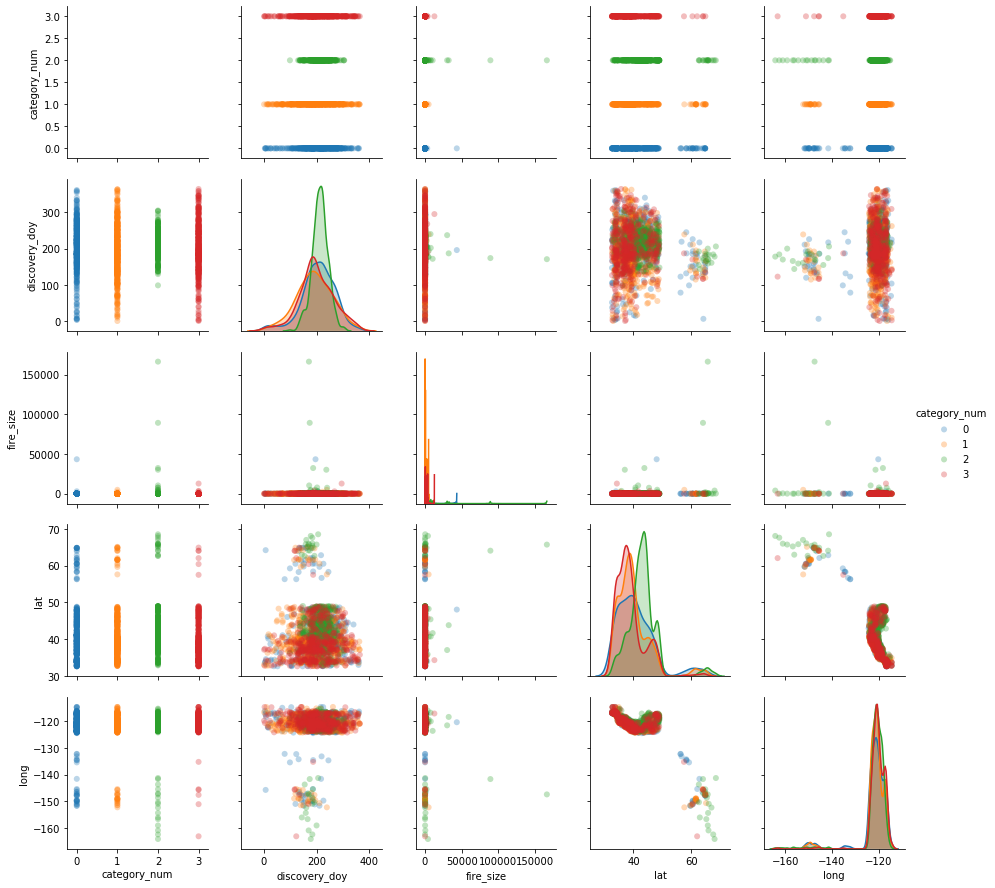

In [75]:
plot_features_2(model2_df)

Well, it's not ideal. No obvious separations.

Looks like there's some scaling issues with fire_size. Consider applying StandardScaler.

# Pick a metric to optimize

I will be working with ROC/AUC score for now.

# Create functions for testing models

In [76]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier()
# from sklearn.linear_model import LogisticRegression
# logit = LogisticRegression()
# from sklearn.tree import DecisionTreeClassifier
# decisiontree = DecisionTreeClassifier(max_depth=4)
# from sklearn.svm import LinearSVC
# linearsvc = LinearSVC()
# from sklearn.svm import SVC
# svc = SVC(kernel='poly', gamma='auto')
# from sklearn.ensemble import RandomForestClassifier
# randomforest = RandomForestClassifier(n_estimators=10)

## Some reference code for repeating fits - do not run

In [77]:
# def quick_test(model, X, y):
#     xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
#     model.fit(xtrain, ytrain)
#     return model.score(xtest, ytest)

# def quick_test_afew_times(model, X, y, n=10):
#     return np.mean([quick_test(model, X, y) for j in range(n)])

k Nearest Neighbors

In [78]:
# def test_knn(X_train, y_train):
#     knn = KNeighborsClassifier(n_neighbors=5)
#     print("The score for kNN is")
#     print("Training: {:6.2f}%".format(100*quick_test_afew_times(knn, X_train, y_train)))


Logistic Regression

In [79]:
# def test_log_reg(X_train, y_train):
#     logit = LogisticRegression(C = 0.5)
#     print("The score for logistic regression is")
#     print("Training: {:6.2f}%".format(100*quick_test_afew_times(logit, X_train, y_train)))

Decision Tree

In [80]:
# def test_decision_tree(X_train, y_train):
#     decisiontree = DecisionTreeClassifier(max_depth=4)
#     print("The score for Decision Tree Classifier is")
#     print("Training: {:6.2f}%".format(100*quick_test_afew_times(decisiontree, X_train, y_train)))

Linear SVC

In [81]:
# def test_linearsvc(X_train, y_train):
#     linearsvc = LinearSVC()
#     print("The score for Linear SVC is")
#     print("Training: {:6.2f}%".format(100*quick_test_afew_times(linearsvc, X_train, y_train)))

Polynomial SVC

In [82]:
# def test_svc(X_train, y_train):
#     svc = SVC(kernel='poly', gamma='auto')
#     print("The score for Polynomial SVC is")
#     print("Training: {:6.2f}%".format(100*quick_test_afew_times(svc, X_train, y_train)))

Random Forest

In [83]:
# def test_randomforest(X_train, y_train):
#     randomforest = RandomForestClassifier(n_estimators=10)
#     print("The score for Random Forest is")
#     print("Training: {:6.2f}%".format(100*quick_test_afew_times(randomforest, X_train, y_train)))

# Model 3: imposed binary: miscellaneous (0) or not (1)

This section is meant to help me figure out how to create models and ROC/AUC scores.

In [84]:
model3_df = model2_df.copy()

In [85]:
model3_df.shape

(282047, 13)

## create misc_or_not df

In [86]:
def make_binary_classifier(cause_code):
    '''
    Returns 0 for 'miscellaneous' and 1 for everything else.
    '''
    if cause_code == 9.0:
        # return category
        return 0        
    else:
        return 1

In [87]:
model3_df['misc_or_not']=model2_df['cause_code'].apply(make_binary_classifier)

In [88]:
model3_df.head()

,fire_id,year,discovery_doy,cause_code,cause_descr,contained_doy,fire_size,fire_size_class,lat,long,state,cause_category,category_num,misc_or_not
0,FS-1418826,2005,33,9.0,Miscellaneous,33.0,0.10,A,40.036944,-121.005833,CA,misc,3,0
1,FS-1418827,2004,133,1.0,Lightning,133.0,0.25,A,38.933056,-120.404444,CA,natural,2,1
2,FS-1418835,2004,152,5.0,Debris Burning,152.0,0.10,A,38.984167,-120.735556,CA,human_ind,1,1
3,FS-1418845,2004,180,1.0,Lightning,185.0,0.10,A,38.559167,-119.913333,CA,natural,2,1
4,FS-1418847,2004,180,1.0,Lightning,185.0,0.10,A,38.559167,-119.933056,CA,natural,2,1


## define X and y

In [89]:
X_3 = model3_df[['discovery_doy','fire_size','lat','long']]

y_3 = model3_df['misc_or_not']

## look at pairplot with binary split

In [90]:
def plot_features_3(df, sample_size=500):
    
    sample = df[['misc_or_not','discovery_doy','fire_size','lat','long']].sample(2000, random_state=44)
    sns.pairplot(sample,hue='misc_or_not', plot_kws=dict(alpha=.3, edgecolor='none'))


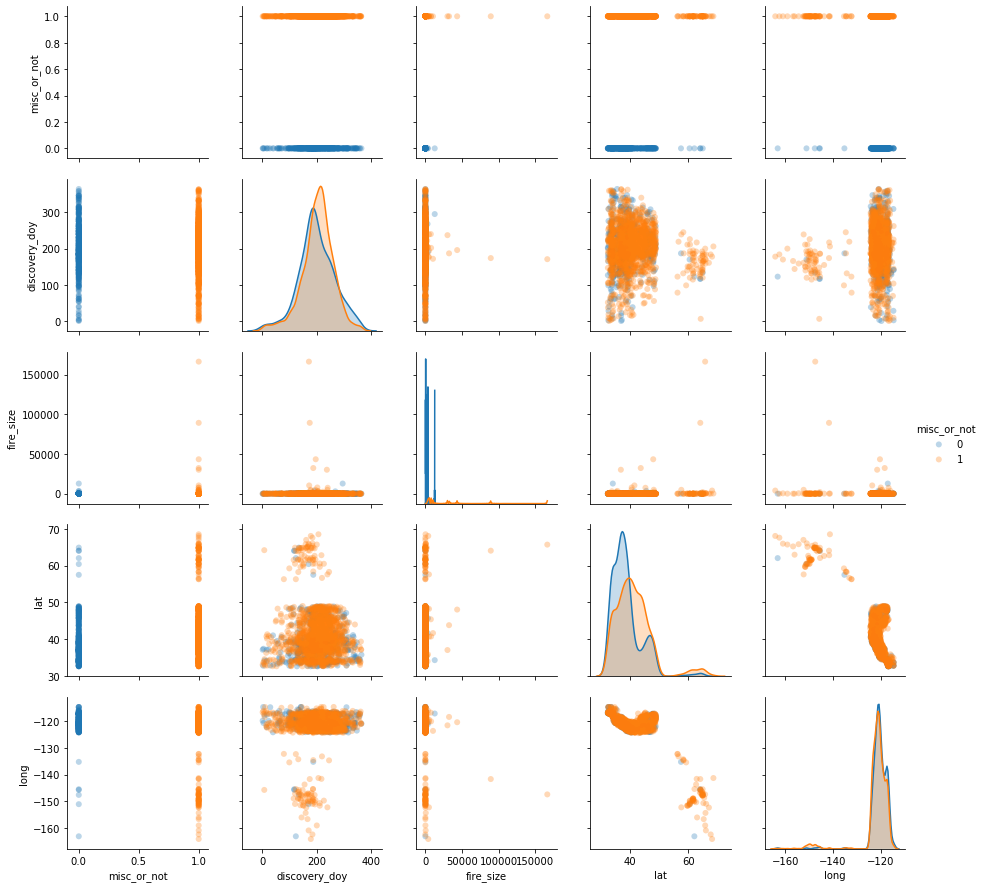

In [91]:
plot_features_3(model3_df)

## do a transform on fire_size

In [92]:
# later

## train test split

In [93]:
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=.2)

## create validation set

In [94]:
X_3_train, X_3_val, y_3_train, y_3_val = train_test_split(X_3_train, y_3_train, test_size=0.25)

Now, X_3_train and y_3_train are the true training sets.

In [95]:
y_3_train.shape

(169227,)

## Find ROC/AUC scores

In [96]:
# from sklearn.metrics import roc_auc_score, roc_curve

### Logistic Regression

In [97]:
# default model
logit = LogisticRegression(solver='lbfgs')
logit.fit(X_3_train, y_3_train)
y_3_pred = logit.predict(X_3_val)
print("Logistic Regression confusion matrix: \n", confusion_matrix(y_3_val, y_3_pred))

fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_3_val, logit.predict_proba(X_3_val)[:,1])

Logistic Regression confusion matrix: 
 [[    0 13144]
 [    0 43266]]


In [98]:
logit_100k = LogisticRegression(solver='lbfgs', C=100000)
logit_100k.fit(X_3_train, y_3_train)
y_3_pred = logit_100k.predict(X_3_val)
print("Logistic Regression confusion matrix: \n", confusion_matrix(y_3_val, y_3_pred))

fpr_logit_100k, tpr_logit_100k, thresholds_logit_100k = roc_curve(y_3_val, logit_100k.predict_proba(X_3_val)[:,1])
# plt.plot(fpr_logit_100k, tpr_logit_100k,lw=2)

Logistic Regression confusion matrix: 
 [[    0 13144]
 [    0 43266]]


Changing the value of C seems to make absolutely no difference.

ROC AUC score for C=1.0:  0.6380597648092303
ROC AUC score for C=0.90:  0.638065034831453


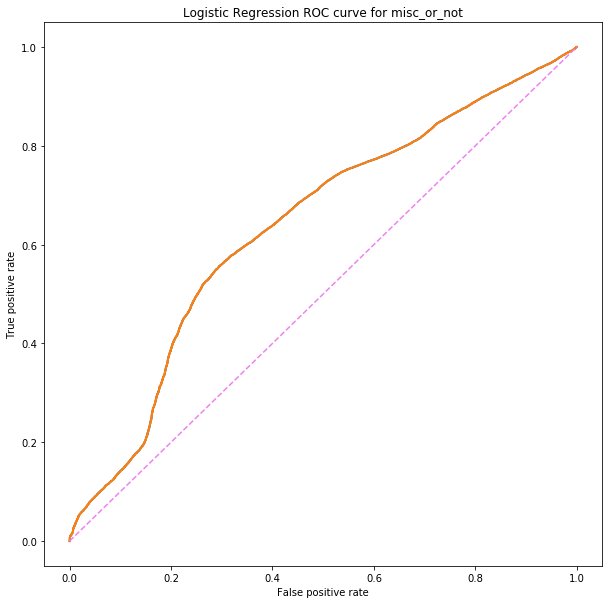

In [99]:
plt.figure(figsize=[10,10])
plt.plot(fpr_logit, tpr_logit,lw=2)
plt.plot(fpr_logit_100k, tpr_logit_100k,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression ROC curve for misc_or_not');
print("ROC AUC score for C=1.0: ", roc_auc_score(y_3_val, logit.predict_proba(X_3_val)[:,1]))
print("ROC AUC score for C=0.90: ", roc_auc_score(y_3_val, logit_100k.predict_proba(X_3_val)[:,1]))

### KNN

In [100]:
knn_3 = KNeighborsClassifier(n_neighbors = 3)
knn_3.fit(X_3_train, y_3_train)
fpr_knn_3, tpr_knn_3, thresholds_knn = roc_curve(y_3_val, knn_3.predict_proba(X_3_val)[:,1])

In [101]:
knn_5 = KNeighborsClassifier(n_neighbors = 5)
knn_5.fit(X_3_train, y_3_train)
fpr_knn_5, tpr_knn_5, thresholds_knn = roc_curve(y_3_val, knn_5.predict_proba(X_3_val)[:,1])

In [102]:
knn_7 = KNeighborsClassifier(n_neighbors = 7)
knn_7.fit(X_3_train, y_3_train)
fpr_knn_7, tpr_knn_7, thresholds_knn = roc_curve(y_3_val, knn_7.predict_proba(X_3_val)[:,1])

In [103]:
knn_9 = KNeighborsClassifier(n_neighbors = 9)
knn_9.fit(X_3_train, y_3_train)
fpr_knn_9, tpr_knn_9, thresholds_knn = roc_curve(y_3_val, knn_9.predict_proba(X_3_val)[:,1])

In [104]:
knn_15 = KNeighborsClassifier(n_neighbors = 15)
knn_15.fit(X_3_train, y_3_train)
fpr_knn_15, tpr_knn_15, thresholds_knn = roc_curve(y_3_val, knn_15.predict_proba(X_3_val)[:,1])

In [105]:
knn_25 = KNeighborsClassifier(n_neighbors = 25)
knn_25.fit(X_3_train, y_3_train)
fpr_knn_25, tpr_knn_25, thresholds_knn = roc_curve(y_3_val, knn_25.predict_proba(X_3_val)[:,1])

In [106]:
knn_50 = KNeighborsClassifier(n_neighbors = 50)
knn_50.fit(X_3_train, y_3_train)
fpr_knn_50, tpr_knn_50, thresholds_knn = roc_curve(y_3_val, knn_50.predict_proba(X_3_val)[:,1])

ROC AUC score for 3 neighbors =  0.6211005510674262
ROC AUC score for 5 neighbors =  0.640454238179655
ROC AUC score for 7 neighbors =  0.6542530343652012
ROC AUC score for 9 neighbors =  0.6612494847441069
ROC AUC score for 15 neighbors =  0.6740279829985741
ROC AUC score for 25 neighbors =  0.6831874882378449
ROC AUC score for 50 neighbors =  0.6887801757920451


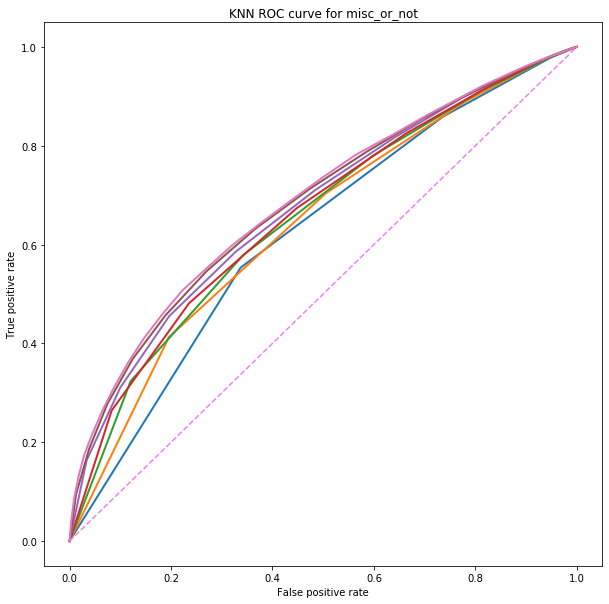

In [107]:
plt.figure(figsize=[10,10])
plt.plot(fpr_knn_3, tpr_knn_3,lw=2)
plt.plot(fpr_knn_5, tpr_knn_5,lw=2)
plt.plot(fpr_knn_7, tpr_knn_7,lw=2)
plt.plot(fpr_knn_9, tpr_knn_9,lw=2)
plt.plot(fpr_knn_15, tpr_knn_15,lw=2)
plt.plot(fpr_knn_25, tpr_knn_25,lw=2)
plt.plot(fpr_knn_50, tpr_knn_50,lw=2)

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('KNN ROC curve for misc_or_not');
print("ROC AUC score for 3 neighbors = ", roc_auc_score(y_3_val, knn_3.predict_proba(X_3_val)[:,1]))
print("ROC AUC score for 5 neighbors = ", roc_auc_score(y_3_val, knn_5.predict_proba(X_3_val)[:,1]))
print("ROC AUC score for 7 neighbors = ", roc_auc_score(y_3_val, knn_7.predict_proba(X_3_val)[:,1]))
print("ROC AUC score for 9 neighbors = ", roc_auc_score(y_3_val, knn_9.predict_proba(X_3_val)[:,1]))
print("ROC AUC score for 15 neighbors = ", roc_auc_score(y_3_val, knn_15.predict_proba(X_3_val)[:,1]))
print("ROC AUC score for 25 neighbors = ", roc_auc_score(y_3_val, knn_25.predict_proba(X_3_val)[:,1]))
print("ROC AUC score for 50 neighbors = ", roc_auc_score(y_3_val, knn_50.predict_proba(X_3_val)[:,1]))


KNN diminishing returns at n_neighbors > 25

### Decision Tree

In [108]:
decisiontree_4 = DecisionTreeClassifier(max_depth=4)
decisiontree_4.fit(X_3_train, y_3_train)
fpr_decisiontree_4, tpr_decisiontree_4, thresholds_decisiontree_4 = roc_curve(y_3_val, decisiontree_4.predict_proba(X_3_val)[:,1])

In [109]:
decisiontree_10 = DecisionTreeClassifier(max_depth=10)
decisiontree_10.fit(X_3_train, y_3_train)
fpr_decisiontree_10, tpr_decisiontree_10, thresholds_decisiontree_10 = roc_curve(y_3_val, decisiontree_10.predict_proba(X_3_val)[:,1])

In [110]:
decisiontree_9 = DecisionTreeClassifier(max_depth=9)
decisiontree_9.fit(X_3_train, y_3_train)
fpr_decisiontree_9, tpr_decisiontree_9, thresholds_decisiontree_9 = roc_curve(y_3_val, decisiontree_9.predict_proba(X_3_val)[:,1])

ROC AUC score for max_depth=4:  0.68879692310324
ROC AUC score for max_depth=10:  0.71449457311153
ROC AUC score for max_depth=9:  0.7138353947929971


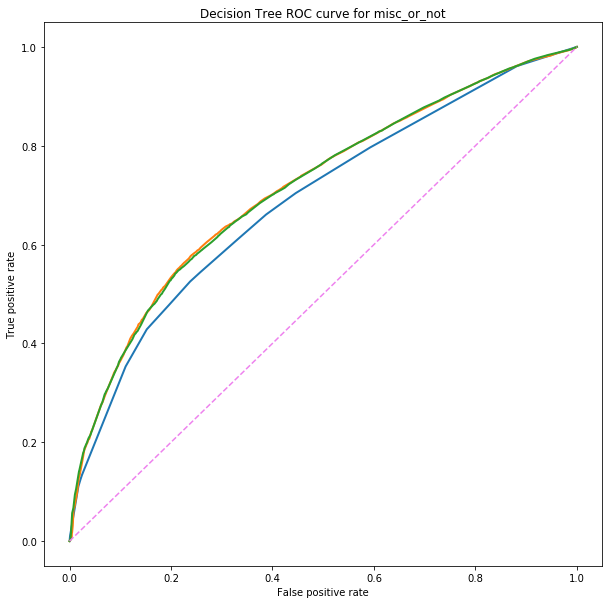

In [111]:
plt.figure(figsize=[10,10])
plt.plot(fpr_decisiontree_4, tpr_decisiontree_4,lw=2)
plt.plot(fpr_decisiontree_10, tpr_decisiontree_10,lw=2)
plt.plot(fpr_decisiontree_9, tpr_decisiontree_9,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Decision Tree ROC curve for misc_or_not');
print("ROC AUC score for max_depth=4: ", roc_auc_score(y_3_val, decisiontree_4.predict_proba(X_3_val)[:,1]))
print("ROC AUC score for max_depth=10: ", roc_auc_score(y_3_val, decisiontree_10.predict_proba(X_3_val)[:,1]))
print("ROC AUC score for max_depth=9: ", roc_auc_score(y_3_val, decisiontree_9.predict_proba(X_3_val)[:,1]))

### Linear SVC - need to find an equivalent for predict_proba (do not run these; too slow)

In [112]:
# linearsvc = SVC(kernel='linear')
# linearsvc.fit(X_3_train, y_3_train)
# fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_3_val, linearsvc.probA_(X_3_val)[:,1])

In [113]:
# plt.plot(fpr_svc, tpr_svc,lw=2)
# plt.plot([0,1],[0,1],c='violet',ls='--')
# plt.xlim([-0.05,1.05])
# plt.ylim([-0.05,1.05])


# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('Linear SVC ROC curve for misc_or_not');
# print("ROC AUC score = ", roc_auc_score(y_3_val, linearsvc.probA_(X_3_val)[:,1]))

### Random Forest

#### n=10

In [114]:
randomforest_10 = RandomForestClassifier(n_estimators=10)
randomforest_10.fit(X_3_train, y_3_train)
fpr_10, tpr_10, thresholds_10 = roc_curve(y_3_val, randomforest_10.predict_proba(X_3_val)[:,1])

#### n=20

In [115]:
randomforest_20 = RandomForestClassifier(n_estimators=20)
randomforest_20.fit(X_3_train, y_3_train)
fpr_20, tpr_20, thresholds_20 = roc_curve(y_3_val, randomforest_20.predict_proba(X_3_val)[:,1])

#### n=50

In [116]:
randomforest_50 = RandomForestClassifier(n_estimators=50)
randomforest_50.fit(X_3_train, y_3_train)
fpr_50, tpr_50, thresholds_50 = roc_curve(y_3_val, randomforest_50.predict_proba(X_3_val)[:,1])

#### n=100

In [117]:
randomforest_100 = RandomForestClassifier(n_estimators=100)
randomforest_100.fit(X_3_train, y_3_train)
fpr_100, tpr_100, thresholds_100 = roc_curve(y_3_val, randomforest_100.predict_proba(X_3_val)[:,1])

#### overlay plot with different n values

ROC AUC score for n=10:  0.692498326816301
ROC AUC score for n=20:  0.711570137197687
ROC AUC score for n=50:  0.7221193747286915
ROC AUC score for n=100:  0.7262343318740032


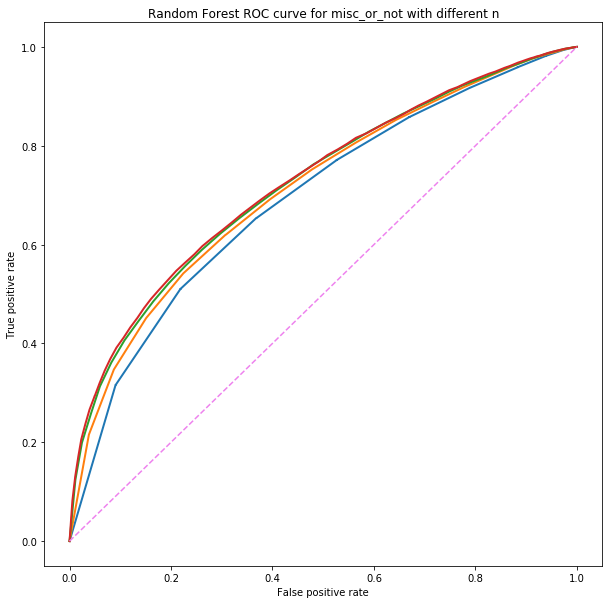

In [118]:
plt.figure(figsize=[10,10])
plt.plot(fpr_10, tpr_10,lw=2)
plt.plot(fpr_20, tpr_20,lw=2)
plt.plot(fpr_50, tpr_50,lw=2)
plt.plot(fpr_100, tpr_100,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Random Forest ROC curve for misc_or_not with different n');
print("ROC AUC score for n=10: ", roc_auc_score(y_3_val, randomforest_10.predict_proba(X_3_val)[:,1]))
print("ROC AUC score for n=20: ", roc_auc_score(y_3_val, randomforest_20.predict_proba(X_3_val)[:,1]))
print("ROC AUC score for n=50: ", roc_auc_score(y_3_val, randomforest_50.predict_proba(X_3_val)[:,1]))
print("ROC AUC score for n=100: ", roc_auc_score(y_3_val, randomforest_100.predict_proba(X_3_val)[:,1]))

Random Forest diminishing returns at n_estimators > 100

# Multi-class ROC for Model 2

Instructions from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [119]:
model2_bin = model2_df.copy() # create a copy of model2_df in order to binarize

In [120]:
# X_val_train, X_val, y_val_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42)

# X = model2_df[['discovery_doy','fire_size','lat','long']]
# y = model2_df['category_num']

In [121]:
X_bin = model2_bin[['discovery_doy','fire_size','lat','long']]
y_bin = model2_bin['category_num']

In [122]:
from itertools import cycle

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Binarize the output
y_bin = label_binarize(y_bin, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

In [123]:
# shuffle and split training and test sets
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin, y_bin, test_size=.2, random_state=42)

In [124]:
# shuffle and split training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_bin_train, y_bin_train, test_size=.25, random_state=42)

In [125]:
X_train.shape

(169227, 4)

In [126]:
# predict each class against the other
def multi_class_ROC(model):
    classifier = OneVsRestClassifier(model)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_val)
        
    # Compute ROC curve and ROC area for each class
    fpr_bin = dict()
    tpr_bin = dict()
    roc_auc_bin = dict()
    for i in range(n_classes):
        fpr_bin[i], tpr_bin[i], _ = roc_curve(y_val[:, i], y_score[:, i])
        roc_auc_bin[i] = auc(fpr_bin[i], tpr_bin[i])

    # Compute micro-average ROC curve and ROC area
    fpr_bin["micro"], tpr_bin["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
    roc_auc_bin["micro"] = auc(fpr_bin["micro"], tpr_bin["micro"])
    
    return fpr_bin, tpr_bin, roc_auc_bin

In [178]:
def multi_class_plot(model):
    fpr_bin, tpr_bin, roc_auc_bin = multi_class_ROC(model)
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr_bin[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr_bin[i], tpr_bin[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr_bin["macro"] = all_fpr
    tpr_bin["macro"] = mean_tpr
    roc_auc_bin["macro"] = auc(fpr_bin["macro"], tpr_bin["macro"])

    # Plot all ROC curves
    plt.figure(figsize=[5,5])
#     plt.plot(fpr_bin["micro"], tpr_bin["micro"],
#              label='micro-average ROC curve (area = {0:0.2f})'
#                    ''.format(roc_auc_bin["micro"]),
#              color='purple', linestyle=':', linewidth=4)

#     plt.plot(fpr_bin["macro"], tpr_bin["macro"],
#              label='macro-average ROC curve (area = {0:0.2f})'
#                    ''.format(roc_auc_bin["macro"]),
#              color='navy', linestyle=':', linewidth=4)

    colors = cycle(['red', 'brown', 'darkorange', 'darkgoldenrod'])
    for i, color in zip(range(n_classes), colors):
        category = cat_num_df['Category'][i]
        plt.plot(fpr_bin[i], tpr_bin[i], color=color, lw=2,
                 label='{0} (area = {1:0.2f})'
                 ''.format(category, roc_auc_bin[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Example ROC Curve: Categorized Causes')
    plt.legend(loc="lower right")
    plt.show()
    
    plt.savefig('example_roc_1.jpg')

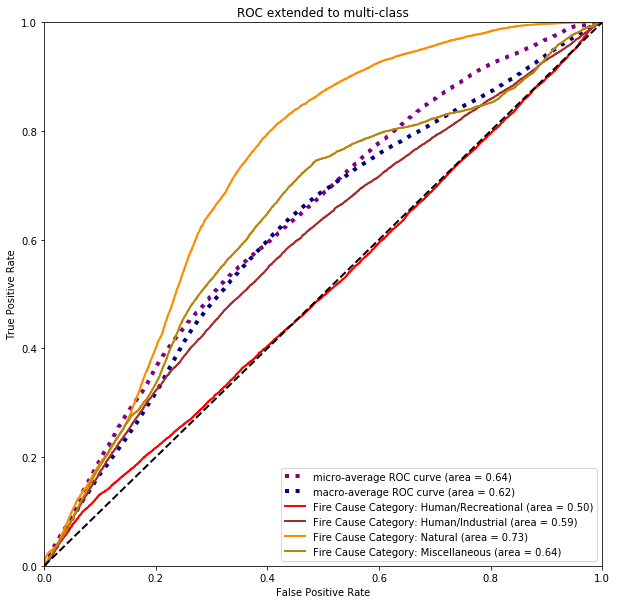

In [128]:
# test the function with a basic model
multi_class_plot(LogisticRegression(solver='lbfgs'))

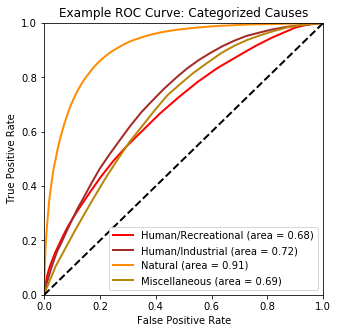

<Figure size 432x288 with 0 Axes>

In [179]:
# try the function with an "optimized" 
multi_class_plot(KNeighborsClassifier(n_neighbors = 50))

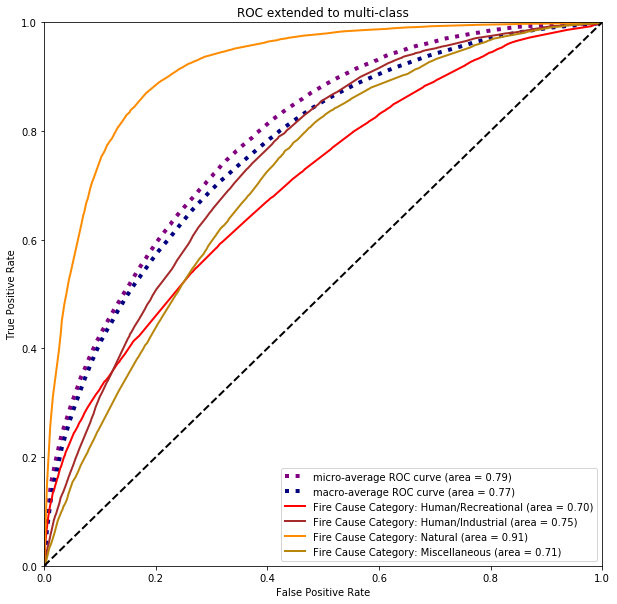

In [130]:
multi_class_plot(DecisionTreeClassifier(max_depth=9))

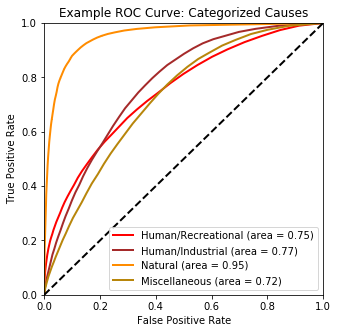

<Figure size 432x288 with 0 Axes>

In [175]:
multi_class_plot(RandomForestClassifier(n_estimators=50)) # expect this to be better than Decision Tree
plt.savefig('example_roc_1.png')

In [132]:
cat_num_df

,cause_category,category_number,Category
0,human_rec,0,Human/Recreational
1,human_ind,1,Human/Industrial
2,natural,2,Natural
3,misc,3,Miscellaneous


# Find a nice way to plot fireworks_df

# Model 4: natural vs unnatural

In [133]:
model4_df = model2_df.copy()

## impose binary classifier

In [134]:
def make_binary_natural(cause_category):
    '''
    Returns 0 for 'natural' and 1 for everything else.
    '''
    if cause_category == 'natural':
        # return category
        return 0        
    else:
        return 1

In [135]:
model4_df['natural_or_not']=model2_df['cause_category'].apply(make_binary_natural)

In [136]:
model4_df.head()

,fire_id,year,discovery_doy,cause_code,cause_descr,contained_doy,fire_size,fire_size_class,lat,long,state,cause_category,category_num,natural_or_not
0,FS-1418826,2005,33,9.0,Miscellaneous,33.0,0.10,A,40.036944,-121.005833,CA,misc,3,1
1,FS-1418827,2004,133,1.0,Lightning,133.0,0.25,A,38.933056,-120.404444,CA,natural,2,0
2,FS-1418835,2004,152,5.0,Debris Burning,152.0,0.10,A,38.984167,-120.735556,CA,human_ind,1,1
3,FS-1418845,2004,180,1.0,Lightning,185.0,0.10,A,38.559167,-119.913333,CA,natural,2,0
4,FS-1418847,2004,180,1.0,Lightning,185.0,0.10,A,38.559167,-119.933056,CA,natural,2,0


## define X_4 and y_4

In [137]:
X_4 = model4_df[['discovery_doy','fire_size','lat','long']]

y_4 = model4_df['natural_or_not']

## train test split

Split into "train and validation" (80%) and "test" (20%) sets.

In [138]:
X_4_train_val, X_4_test, y_4_train_val, y_4_test = train_test_split(X_4, y_4, test_size=.2)

## validation split

Split "train and validation" into "train" and "validate" sets.

In [139]:
X_4_train, X_4_val, y_4_train, y_4_val = train_test_split(X_4_train_val, y_4_train_val, test_size=0.25)

## pair plot

In [140]:
def plot_features_4(df, sample_size=500):
    
    sample = df[['natural_or_not','discovery_doy','fire_size','lat','long']].sample(2000, random_state=44)
    sns.pairplot(sample,hue='natural_or_not', plot_kws=dict(alpha=.3, edgecolor='none'))


/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


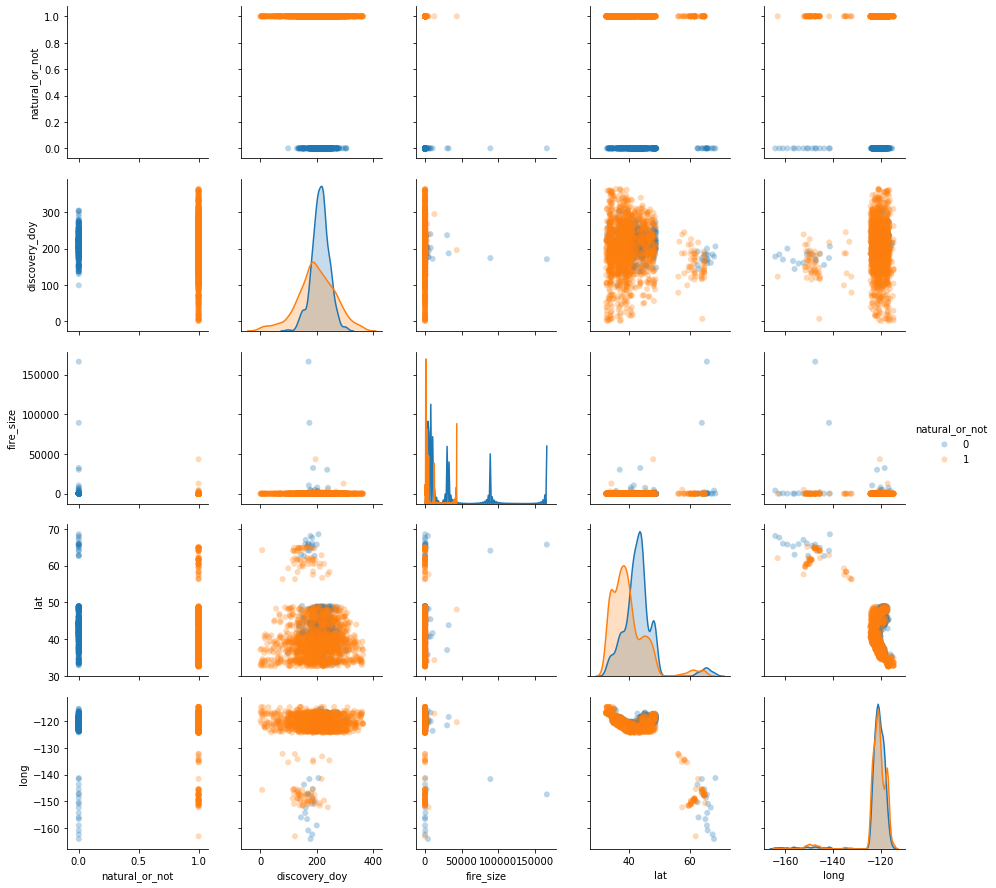

In [141]:
plot_features_4(model4_df)

A few separations becoming apparent.

## test models: Logistic Regression, KNN, Decision Tree, Random Forest

Use parameters giving max ROC AUCs from tests above.

### Logistic Regression

In [142]:
logit = LogisticRegression(solver='lbfgs')
logit.fit(X_4_train, y_4_train)
y_4_pred = logit.predict(X_4_val)
print("Logistic Regression confusion matrix: \n", confusion_matrix(y_4_val, y_4_pred))

fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_4_val, logit.predict_proba(X_4_val)[:,1])

Logistic Regression confusion matrix: 
 [[ 1608 12937]
 [ 2305 39560]]


ROC AUC score for C=1.0:  0.3733963491185146


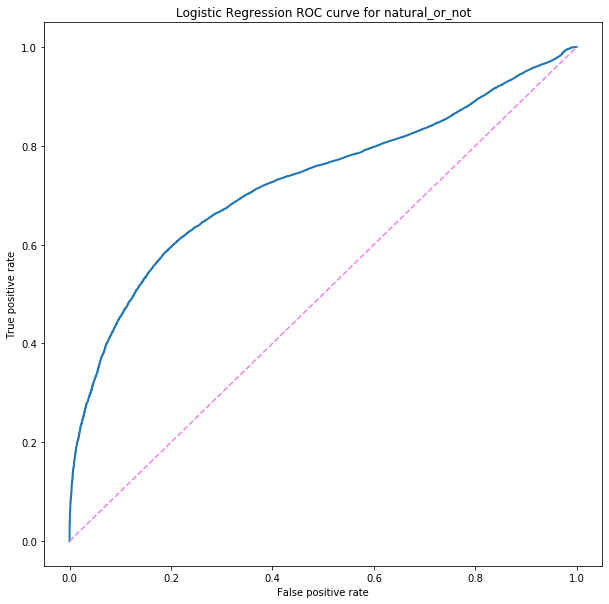

In [143]:
plt.figure(figsize=[10,10])
plt.plot(fpr_logit, tpr_logit,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression ROC curve for natural_or_not');
print("ROC AUC score for C=1.0: ", roc_auc_score(y_3_val, logit.predict_proba(X_3_val)[:,1]))

### KNN

In [144]:
knn_50 = KNeighborsClassifier(n_neighbors = 50)
knn_50.fit(X_4_train, y_4_train)
y_4_pred = knn_50.predict(X_4_val)
print("Logistic Regression confusion matrix: \n", confusion_matrix(y_4_val, y_4_pred))
fpr_knn_50, tpr_knn_50, thresholds_knn = roc_curve(y_4_val, knn_50.predict_proba(X_4_val)[:,1])

Logistic Regression confusion matrix: 
 [[ 9495  5050]
 [ 3188 38677]]


ROC AUC score for 50 neighbors =  0.909664079695671


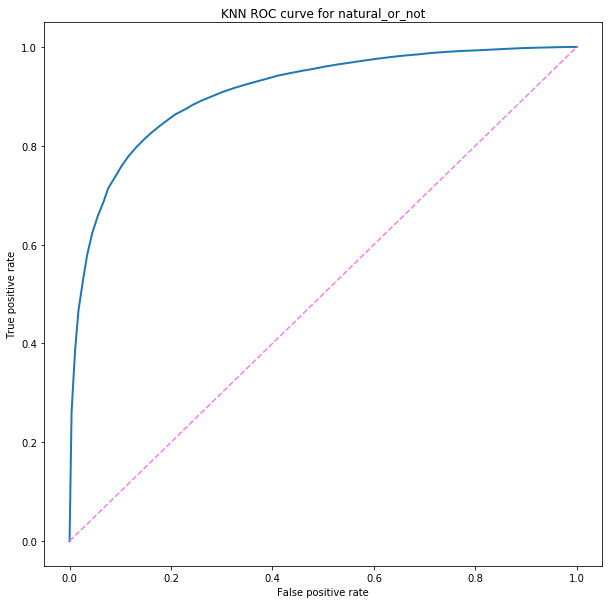

In [145]:
plt.figure(figsize=[10,10])
plt.plot(fpr_knn_50, tpr_knn_50,lw=2)

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('KNN ROC curve for natural_or_not');

print("ROC AUC score for 50 neighbors = ", roc_auc_score(y_4_val, knn_50.predict_proba(X_4_val)[:,1]))


### Decision Tree

In [146]:
decisiontree_4 = DecisionTreeClassifier(max_depth=4)
decisiontree_4.fit(X_4_train, y_4_train)
fpr_decisiontree_4, tpr_decisiontree_4, thresholds_decisiontree_4 = roc_curve(y_4_val, decisiontree_4.predict_proba(X_4_val)[:,1])

decisiontree_9 = DecisionTreeClassifier(max_depth=9)
decisiontree_9.fit(X_4_train, y_4_train)
fpr_decisiontree_9, tpr_decisiontree_9, thresholds_decisiontree_9 = roc_curve(y_4_val, decisiontree_9.predict_proba(X_4_val)[:,1])

decisiontree_10 = DecisionTreeClassifier(max_depth=10)
decisiontree_10.fit(X_4_train, y_4_train)
fpr_decisiontree_10, tpr_decisiontree_10, thresholds_decisiontree_10 = roc_curve(y_4_val, decisiontree_10.predict_proba(X_4_val)[:,1])



In [147]:
decisiontree_11 = DecisionTreeClassifier(max_depth=11)
decisiontree_11.fit(X_4_train, y_4_train)
fpr_decisiontree_11, tpr_decisiontree_11, thresholds_decisiontree_11 = roc_curve(y_4_val, decisiontree_11.predict_proba(X_4_val)[:,1])


ROC AUC score for max_depth=4:  0.8374138123501538
ROC AUC score for max_depth=9:  0.9136229742369942
ROC AUC score for max_depth=10:  0.9182621504724483
ROC AUC score for max_depth=11:  0.9193001863895134


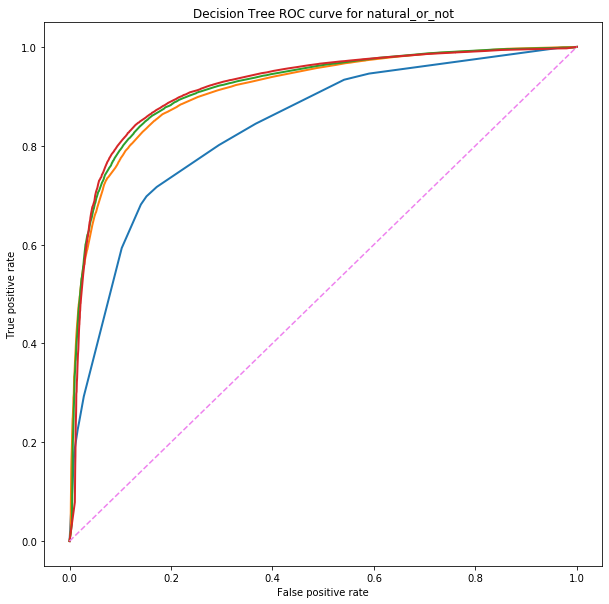

In [148]:
plt.figure(figsize=[10,10])
plt.plot(fpr_decisiontree_4, tpr_decisiontree_4,lw=2)
plt.plot(fpr_decisiontree_9, tpr_decisiontree_9,lw=2)
plt.plot(fpr_decisiontree_10, tpr_decisiontree_10,lw=2)
plt.plot(fpr_decisiontree_11, tpr_decisiontree_11,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Decision Tree ROC curve for natural_or_not');
print("ROC AUC score for max_depth=4: ", roc_auc_score(y_4_val, decisiontree_4.predict_proba(X_4_val)[:,1]))
print("ROC AUC score for max_depth=9: ", roc_auc_score(y_4_val, decisiontree_9.predict_proba(X_4_val)[:,1]))
print("ROC AUC score for max_depth=10: ", roc_auc_score(y_4_val, decisiontree_10.predict_proba(X_4_val)[:,1]))
print("ROC AUC score for max_depth=11: ", roc_auc_score(y_4_val, decisiontree_11.predict_proba(X_4_val)[:,1]))

### Random Forest

In [149]:
#### n=10

randomforest_10 = RandomForestClassifier(n_estimators=10)
randomforest_10.fit(X_4_train, y_4_train)
fpr_10, tpr_10, thresholds_10 = roc_curve(y_4_val, randomforest_10.predict_proba(X_4_val)[:,1])

#### n=20

randomforest_20 = RandomForestClassifier(n_estimators=20)
randomforest_20.fit(X_4_train, y_4_train)
fpr_20, tpr_20, thresholds_20 = roc_curve(y_4_val, randomforest_20.predict_proba(X_4_val)[:,1])

#### n=50

randomforest_50 = RandomForestClassifier(n_estimators=50)
randomforest_50.fit(X_4_train, y_4_train)
fpr_50, tpr_50, thresholds_50 = roc_curve(y_4_val, randomforest_50.predict_proba(X_4_val)[:,1])

#### n=100

randomforest_100 = RandomForestClassifier(n_estimators=100)
randomforest_100.fit(X_4_train, y_4_train)
fpr_100, tpr_100, thresholds_100 = roc_curve(y_4_val, randomforest_100.predict_proba(X_4_val)[:,1])

ROC AUC score for n=10:  0.938568696538338
ROC AUC score for n=20:  0.9465324386275402
ROC AUC score for n=50:  0.9520402263705341
ROC AUC score for n=100:  0.9537239002232493


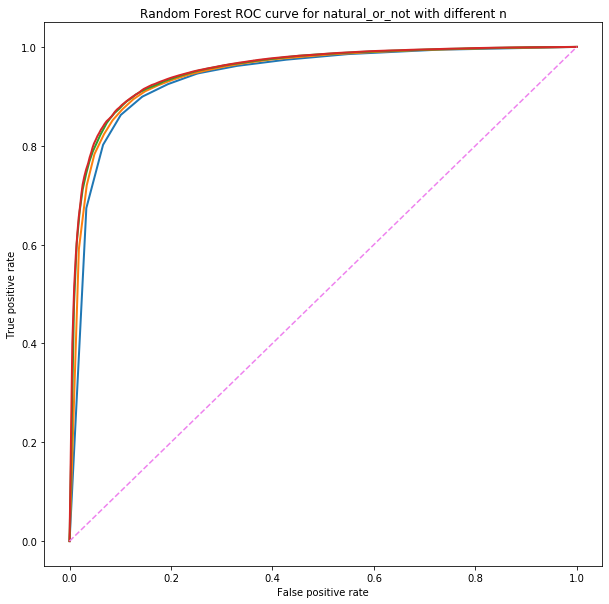

In [150]:
plt.figure(figsize=[10,10])
plt.plot(fpr_10, tpr_10,lw=2)
plt.plot(fpr_20, tpr_20,lw=2)
plt.plot(fpr_50, tpr_50,lw=2)
plt.plot(fpr_100, tpr_100,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Random Forest ROC curve for natural_or_not with different n');
print("ROC AUC score for n=10: ", roc_auc_score(y_4_val, randomforest_10.predict_proba(X_4_val)[:,1]))
print("ROC AUC score for n=20: ", roc_auc_score(y_4_val, randomforest_20.predict_proba(X_4_val)[:,1]))
print("ROC AUC score for n=50: ", roc_auc_score(y_4_val, randomforest_50.predict_proba(X_4_val)[:,1]))
print("ROC AUC score for n=100: ", roc_auc_score(y_4_val, randomforest_100.predict_proba(X_4_val)[:,1]))

Random forest with n=100 gives the best fit! ROC AUC score = 0.95

The difference in score between n=50 and n=100 is negligible, so just use n=50.

## Final analysis: "train and val" vs test set

In [151]:
randomforest_50_final = RandomForestClassifier(n_estimators=50)
randomforest_50_final.fit(X_4_train_val, y_4_train_val)
fpr_50_final, tpr_50_final, thresholds_50_final = roc_curve(y_4_test, randomforest_50_final.predict_proba(X_4_test)[:,1])

In [152]:
train_score = randomforest_50_final.score(X_4_train_val, y_4_train_val)
print("Train score for Final Model: {}".format(train_score))
test_score = randomforest_50_final.score(X_4_test, y_4_test)
print("Test score for Final Model: {}".format(test_score))

Train score for Final Model: 0.9997207904731936
Test score for Final Model: 0.9085800390001773


ROC AUC score for n=50:  0.9565387021128096


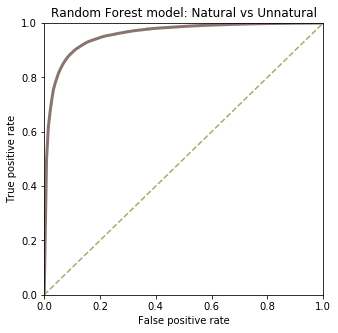

In [173]:
plt.figure(figsize=[5,5])

plt.plot(fpr_50_final, tpr_50_final,lw=3, color='#89746F')
plt.plot([0,1],[0,1],c='#a5ab6f',ls='--')
#e2eb98
#a5ab6f
plt.xlim([0.0,1.0])
plt.ylim([-0.0,1.0])
# plt.hlines(y=[0,1], xmin=-0.05, xmax=1.05,  ls=':') #colors="#a9a9a9",
# plt.vlines(x=[0,1], ymin=-0.05, ymax=1.05, ls=':') #colors="#a9a9a9", 
# final ROC color: #df928e

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Random Forest model: Natural vs Unnatural');

print("ROC AUC score for n=50: ", roc_auc_score(y_4_test, randomforest_50_final.predict_proba(X_4_test)[:,1]))
plt.savefig('roc_final_test_4.png')